# Loading packages


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Loading data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMG_SIZE = (225, 400)
BATCH_SIZE = 32
seed = 123
# root_directory = './'
root_directory = '/content/drive/MyDrive/detect_planes/'
img_directory = root_directory + "img/"
#img_directory = './img/'
train_dataset = image_dataset_from_directory(
    directory=img_directory + 'train/',
    labels='inferred',
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

type(train_dataset)
print(train_dataset)

test_dataset = image_dataset_from_directory(
    directory=img_directory + 'test/',
    labels='inferred',
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

type(test_dataset)
print(test_dataset)

validation_dataset = image_dataset_from_directory(
    directory=img_directory + 'validate/',
    labels='inferred',
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)

type(validation_dataset)
print(validation_dataset)

Found 2080 files belonging to 2 classes.
<BatchDataset shapes: ((None, 225, 400, 3), (None,)), types: (tf.float32, tf.int32)>
Found 520 files belonging to 2 classes.
<BatchDataset shapes: ((None, 225, 400, 3), (None,)), types: (tf.float32, tf.int32)>
Found 520 files belonging to 2 classes.
<BatchDataset shapes: ((None, 225, 400, 3), (None,)), types: (tf.float32, tf.int32)>


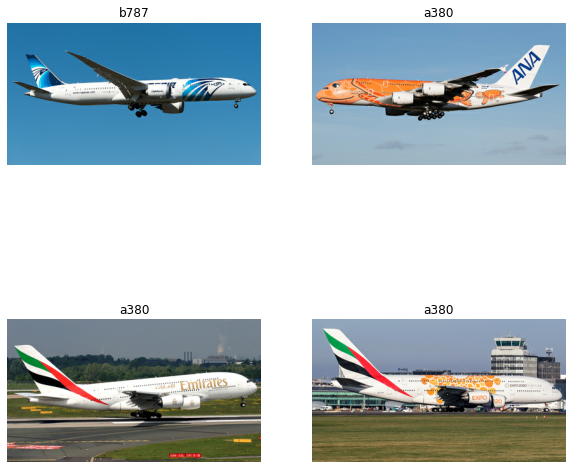

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 65
Number of validation batches: 17
Number of test batches: 17


#Prefetching


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
])

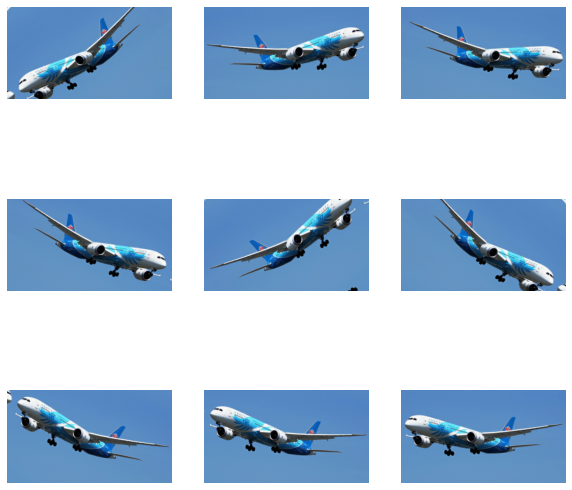

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Rescale pixel values

In [4]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

# Create the base model from the pre-trained convnets

In [ ]:
IMG_SIZE = (225, 400)
BATCH_SIZE = 32

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 8, 13, 1280)


# Feature extraction

## Freeze the convolutional base

In [ ]:
base_model.trainable = False
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 225, 400, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 113, 200, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 113, 200, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 113, 200, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

## Add a classification head
To generate predictions from the block of features, average over the spatial 5x5 spatial locations, using a tf.keras.layers.GlobalAveragePooling2D layer to convert the features to a single 1280-element vector per image.

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Apply a tf.keras.layers.Dense layer to convert these features into a single prediction per image. You don't need an activation function here because this prediction will be treated as a logit, or a raw prediction value. Positive numbers predict class 1, negative numbers predict class 0.


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Build a model by chaining together the data augmentation, rescaling, base_model and feature extractor layers using the Keras Functional API. As previously mentioned, use training=False as our model contains a BatchNormalization layer.

In [ ]:
inputs = tf.keras.Input(shape=(225, 400, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Compiling the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 225, 400, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 225, 400, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 13, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
len(model.trainable_variables)

2

# Train the model

In [ ]:
initial_epochs = 10

# loss0, accuracy0 = model.evaluate(validation_dataset)

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                   validation_data=validation_dataset)

Epoch 1/10
65/65 [==============================] - 281s 4s/step - loss: 0.6911 - accuracy: 0.5296 - val_loss: 0.6973 - val_accuracy: 0.4981
Epoch 2/10
65/65 [==============================] - 184s 3s/step - loss: 0.6926 - accuracy: 0.5227 - val_loss: 0.6892 - val_accuracy: 0.5058
Epoch 3/10
65/65 [==============================] - 182s 3s/step - loss: 0.6791 - accuracy: 0.5311 - val_loss: 0.6800 - val_accuracy: 0.5058
Epoch 4/10
65/65 [==============================] - 183s 3s/step - loss: 0.6638 - accuracy: 0.5457 - val_loss: 0.6735 - val_accuracy: 0.5077
Epoch 5/10
65/65 [==============================] - 183s 3s/step - loss: 0.6437 - accuracy: 0.5693 - val_loss: 0.6645 - val_accuracy: 0.5192
Epoch 6/10
65/65 [==============================] - 181s 3s/step - loss: 0.6390 - accuracy: 0.5874 - val_loss: 0.6578 - val_accuracy: 0.5250
Epoch 7/10
65/65 [==============================] - 182s 3s/step - loss: 0.6191 - accuracy: 0.5901 - val_loss: 0.6502 - val_accuracy: 0.5327
Epoch 8/10
65

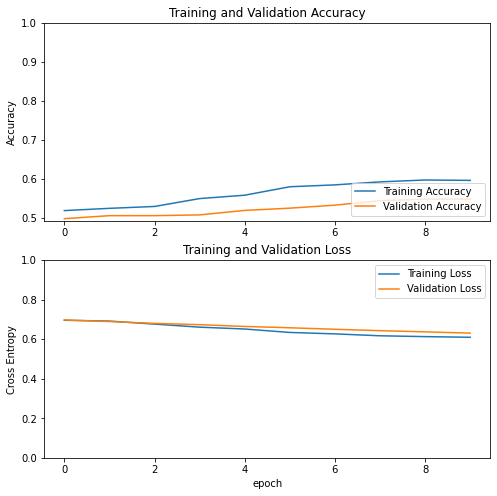

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tuning
## Un-freeze the top layers of the model

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()
len(model.trainable_variables)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 225, 400, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 225, 400, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 225, 400, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 8, 13, 1280)       2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
65/65 [==============================] - 274s 4s/step - loss: 0.5337 - accuracy: 0.6879 - val_loss: 0.4065 - val_accuracy: 0.8654
Epoch 11/20
65/65 [==============================] - 267s 4s/step - loss: 0.3511 - accuracy: 0.8496 - val_loss: 0.2776 - val_accuracy: 0.9135
Epoch 12/20
65/65 [==============================] - 268s 4s/step - loss: 0.2726 - accuracy: 0.8899 - val_loss: 0.2057 - val_accuracy: 0.9135
Epoch 13/20
65/65 [==============================] - 269s 4s/step - loss: 0.1777 - accuracy: 0.9303 - val_loss: 0.1674 - val_accuracy: 0.9558
Epoch 14/20
65/65 [==============================] - 269s 4s/step - loss: 0.1419 - accuracy: 0.9484 - val_loss: 0.1314 - val_accuracy: 0.9519
Epoch 15/20
65/65 [==============================] - 267s 4s/step - loss: 0.1242 - accuracy: 0.9520 - val_loss: 0.1094 - val_accuracy: 0.9635
Epoch 16/20
65/65 [==============================] - 267s 4s/step - loss: 0.1053 - accuracy: 0.9523 - val_loss: 0.1166 - val_accuracy: 0.9615
Epoch 

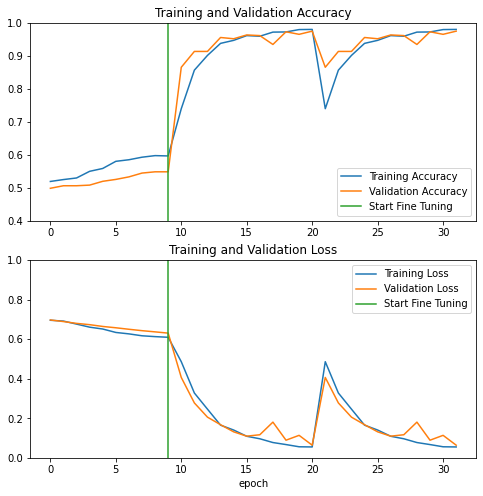

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

17/17 [==============================] - 207s 6s/step - loss: 0.0570 - accuracy: 0.9865
Test accuracy : 0.9865384697914124


# Prediction

Predictions:
 [0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0]
Labels:
 [0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0]


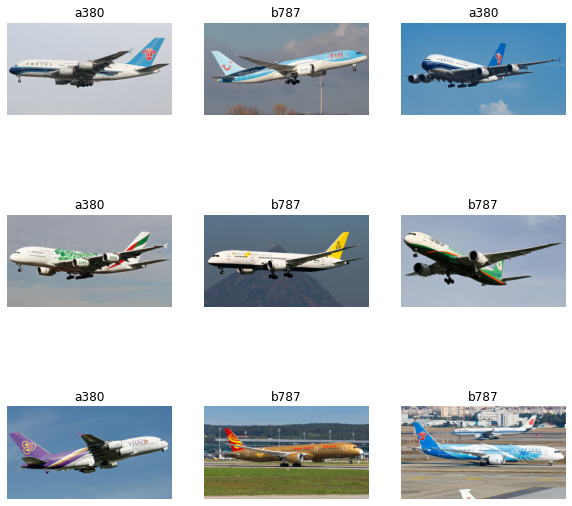

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
model.save(root_directory)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/detect_planes/assets


# LIME: interpretatble modelling

In [5]:
from tensorflow import keras
model = keras.models.load_model(root_directory)

In [8]:
!pip install lime

     |████████████████████████████████| 276kB 8.5MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp36-none-any.whl size=283846 sha256=80ccf72cbacaf0413f9d376b6dd0a8cd680d796d507d3c3b48fdca9aea081f91
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [9]:
import lime
from lime import lime_image
from keras.preprocessing import image

tf.Tensor([[0.36082846]], shape=(1, 1), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


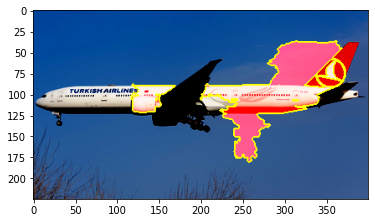

In [13]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

def img_prep(infile, add_batch_dim=True):
  img = image.load_img(infile, target_size=IMG_SIZE)
  img_a = image.img_to_array(img)
  if add_batch_dim:
    img_a = np.expand_dims(img_a, axis=0)
  m = preprocess_input(img_a)
  return m

def img_predict(infile):
  i = img_prep(infile)
  p = model.predict(i)
  return imagenet_utils.decode_predictions(p)

def show_img_exp(infile, model):
  explainer = lime_image.LimeImageExplainer()
  img = img_prep(infile, add_batch_dim=False)
  exp = explainer.explain_instance(img, model.predict, hide_color=0)
  temp_img, mask = exp.get_image_and_mask(exp.top_labels[0], positive_only=False)
  plt.imshow(mark_boundaries(temp_img, mask))
  plt.show()

# selected_img_dir = img_directory + 'test/a380/' + os.listdir(img_directory + 'test/a380')[5]
# selected_img_dir = img_directory + 'additional/a380_airbus/' + os.listdir(img_directory + 'additional/a380_airbus')[2]
selected_img_dir = img_directory + 'additional/b777/' + os.listdir(img_directory + 'additional/b777')[1]
#selected_img_dir = img_directory + 'test/a380/' + os.listdir(img_directory + 'test/a380')[0]
img = image.load_img(selected_img_dir, target_size=IMG_SIZE)
# plt.imshow(img)

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
preds = tf.nn.sigmoid(preds)
preds
print(preds)

show_img_exp(selected_img_dir, model)

#eli5

In [18]:
!pip install eli5

     |████████████████████████████████| 112kB 7.9MB/s 


In [19]:
from PIL import Image
from IPython.display import display
import numpy as np

# you may want to keep logging enabled when doing your own work
import logging
import tensorflow as tf
tf.get_logger().setLevel(logging.ERROR) # disable Tensorflow warnings for this tutorial
import warnings
warnings.simplefilter("ignore") # disable Keras warnings for this tutorial
import keras
from keras.applications import mobilenet_v2

import eli5

In [21]:
root_directory + "img/additional/b777/cdn.jetphotos.com-400-5-89564_1612690329.jpg"

'/content/drive/MyDrive/detect_planes/img/additional/b777/cdn.jetphotos.com-400-5-89564_1612690329.jpg'

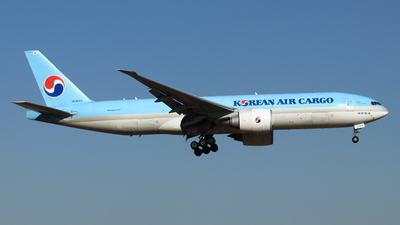

<class 'numpy.ndarray'> (225, 400, 3)
<class 'numpy.ndarray'> (1, 225, 400, 3)


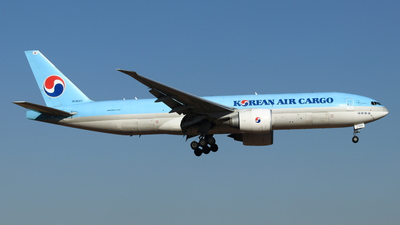

In [27]:
im = keras.preprocessing.image.load_img(root_directory + "img/additional/b777/cdn.jetphotos.com-400-5-89564_1612690329.jpg", target_size=IMG_SIZE) # -> PIL image
display(im)
doc = keras.preprocessing.image.img_to_array(im) # -> numpy array
print(type(doc), doc.shape)

doc = np.expand_dims(doc, axis=0)
print(type(doc), doc.shape)

image = keras.preprocessing.image.array_to_img(doc[0])
display(image)

In [31]:
predictions = model.predict(doc)
print(type(predictions), predictions.shape)
eli5.show_prediction(model, doc)

<class 'numpy.ndarray'> (1, 1)


RuntimeError: ignored

# Additional plane models

In [ ]:
additional_dataset = image_dataset_from_directory(
    directory=img_directory + 'additional/',
    labels='inferred',
    shuffle=True,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE)


Found 68 files belonging to 2 classes.


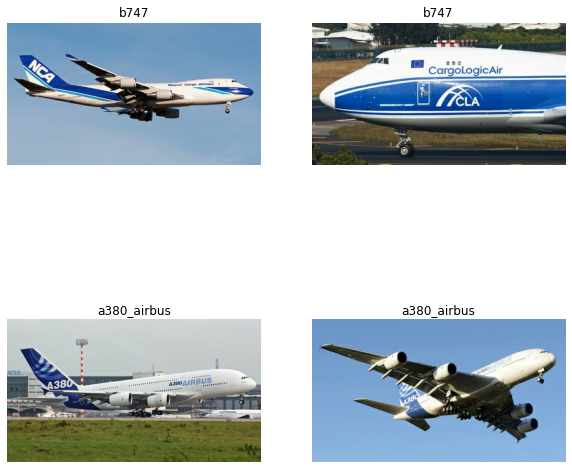

In [ ]:
class_names = additional_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in additional_dataset.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Prediction

Predictions:
 [0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 0 0]
Labels:
 [1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1]


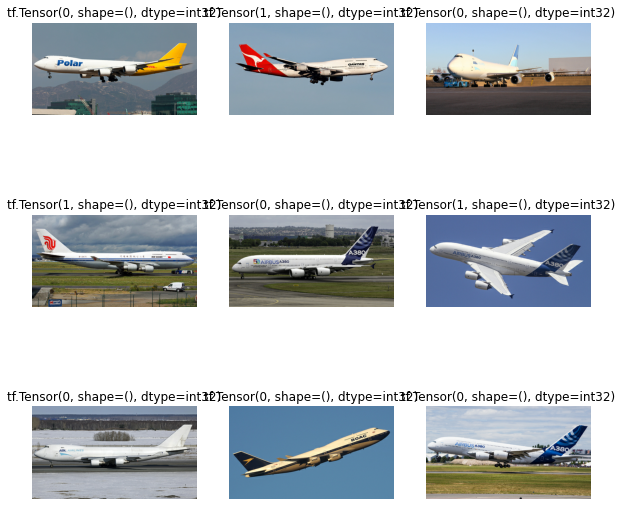

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = additional_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(str(predictions[i]))
  plt.axis("off")

In [ ]:
predictions

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0], dtype=int32)>

# References

+ https://github.com/marcotcr/lime
+ https://paperswithcode.com/method/resnet
+ https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751
+ https://blog.csdn.net/kingroc/article/details/86692156
+ https://www.tensorflow.org/tutorials/images/transfer_learning#create_the_base_model_from_the_pre-trained_convnets

# Additional codes

In [ ]:
# from tensorflow import keras
# model2 = keras.models.load_model(root_directory)

In [ ]:
# import os
# 
# train_dir = img_directory + 'validate/b787/'
# 
# def progress(percent, width=50):
#     '''进度打印功能'''
#     if percent >= 100:
#         percent = 100
# 
#     show_str = ('[%%-%ds]' % width) % (int(width * percent / 100) * "#")  # 字符串拼接的嵌套使用
#     print('\r%s %d%% ' % (show_str, percent), end='')
# 
# def is_valid_jpg(jpg_file):
#     with open(jpg_file, 'rb') as f:
#         f.seek(-2, 2)
#         buf = f.read()
#         f.close()
#         return buf ==  b'\xff\xd9'  # 判定jpg是否包含结束字段
# 
# data_size = len([lists for lists in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, lists))])
# recv_size = 0
# incompleteFile = 0
# print('file tall : %d' % data_size)
# 
# for file in os.listdir(train_dir):
#     if os.path.splitext(file)[1].lower() == '.jpg':
#         ret = is_valid_jpg(train_dir + file)
#         if ret == False:
#             incompleteFile = incompleteFile + 1
#             os.remove(train_dir + file)
# 
#     recv_per = int(100 * recv_size / data_size)
#     progress(recv_per, width=30)
#     recv_size = recv_size + 1
# 
# progress(100, width=30)
# print('\nincomplete file : %d' % incompleteFile)